In [69]:
import pandas as pd

In [88]:
df = pd.read_csv('../data/clean/df_weekly_incidence.csv', parse_dates=True)

In [117]:
df.tail()

,administrative_area_level_3,year,week,confirmed,deaths,recovered,vaccines,people_vaccinated,people_fully_vaccinated,school_closing,...,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,latitude,longitude,population,cfr,cases_per_population,incidence
58915,StadtRegion Aachen,2022,48,239130.857143,1003.571429,238127.285714,1.418742e+06,466328.285714,452488.142857,0.00,...,2.0,2.0,5.0,3.00,50.722553,6.217456,555465.0,0.004197,0.430506,353.217574
58916,StadtRegion Aachen,2022,49,241006.000000,1008.428571,239997.571429,1.420924e+06,466338.857143,452512.714286,0.00,...,2.0,2.0,5.0,3.00,50.722553,6.217456,555465.0,0.004184,0.433882,337.580740
58917,StadtRegion Aachen,2022,50,243497.000000,1014.571429,242482.428571,1.422997e+06,466348.000000,452549.714286,0.00,...,2.0,2.0,5.0,3.00,50.722553,6.217456,555465.0,0.004167,0.438366,448.453098
58918,StadtRegion Aachen,2022,51,246125.142857,1022.000000,245103.142857,1.424413e+06,466359.857143,452564.000000,0.00,...,2.0,2.0,5.0,3.00,50.722553,6.217456,555465.0,0.004152,0.443097,473.142837
58919,StadtRegion Aachen,2022,52,196870.250000,942.625000,195927.250000,1.357966e+06,463290.250000,445556.000000,0.25,...,2.0,2.0,5.0,2.75,50.722553,6.217456,555465.0,0.006964,0.354424,310.370590


In [118]:
X = df[["confirmed", "deaths", "recovered", "vaccines"]].head(25000)
y = df[["incidence"]].tail(25000)

In [119]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

In [120]:
train_size = int(len(X_ss) * 0.8)
valid_size = len(X_ss) - train_size

In [121]:
X_train = X_ss[:train_size, :]
X_test = X_ss[train_size:, :]

y_train = y_mm[:train_size, :]
y_test = y_mm[train_size:, :]

In [122]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (20000, 4) (20000, 1)
Testing Shape (5000, 4) (5000, 1)


In [123]:
import torch #pytorch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [124]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [125]:
#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [126]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([20000, 1, 4]) torch.Size([20000, 1])
Testing Shape torch.Size([5000, 1, 4]) torch.Size([5000, 1])


In [127]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [128]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 4 #number of features
hidden_size = 256 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [129]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [130]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [131]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.03780
Epoch: 100, loss: 0.01341
Epoch: 200, loss: 0.01326
Epoch: 300, loss: 0.01306
Epoch: 400, loss: 0.01281
Epoch: 500, loss: 0.01267
Epoch: 600, loss: 0.01256
Epoch: 700, loss: 0.01244
Epoch: 800, loss: 0.01232
Epoch: 900, loss: 0.01220


In [132]:
df_X_ss = ss.transform(df[['confirmed', 'deaths', 'recovered', 'vaccines']]) #old transformers
df_y_mm = mm.transform(df[['incidence']]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

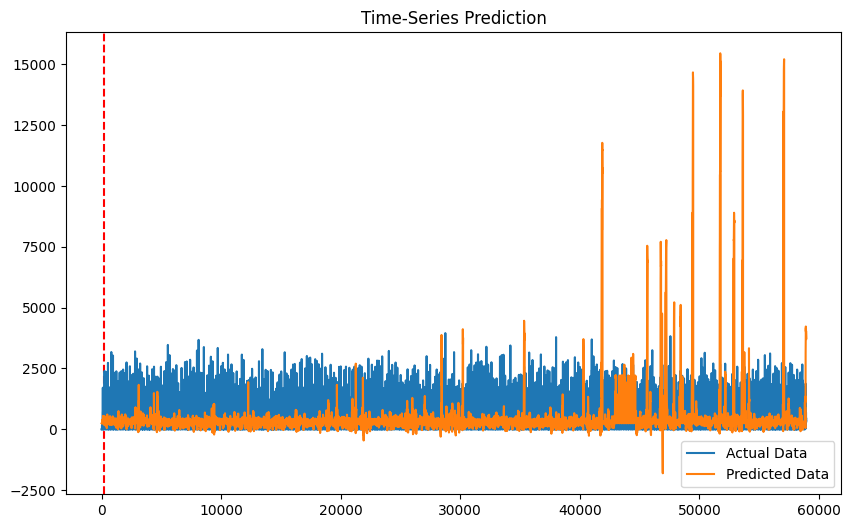

In [133]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()